In [81]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA
import seaborn as sns
import collections
from nltk.util import ngrams
import scipy.cluster.hierarchy as shc
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('emails.csv')

In [5]:
def parse(message):
    m = message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
                
    for i in range(len(m)):
        if "X-FileName" in m[i]:
            k = i
            break
    for i in range(k+2,len(m)):
        message += m[i].strip()
        email['body'] = message
    for line in m:
        if ':' in line:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
        if key in keys_to_extract:
            email[key] = val
    return email

In [6]:
data = pd.DataFrame()
for i in range (2000):
    SR_row = pd.Series(parse(df.iloc[i,1]))
    data = data.append(SR_row,ignore_index=True)
    

In [7]:
for i in range(len(data)):
    if 'Forwarded' in data.body[i]:
        data = data.drop([i], axis=0)
data = data.reset_index(drop=True)

# <center>Preprocessing</center>

In [8]:
data['body'] = data['body'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['body'].head()

0                                 here is our forecast
1    traveling to have a business meeting takes the...
2                        test successful. way to go!!!
3    randy,can you send me a schedule of the salary...
4                    let's shoot for tuesday at 11:45.
Name: body, dtype: object

In [9]:
data['body'] = data['body'].str.replace('[^\w\s]','')
data['body'].head()

0                                 here is our forecast
1    traveling to have a business meeting takes the...
2                            test successful way to go
3    randycan you send me a schedule of the salary ...
4                       lets shoot for tuesday at 1145
Name: body, dtype: object

In [10]:
data['body'] = data['body'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data.head()

,body,from,to
0,here is our forecast,phillip.allen@enron.com,tim.belden@enron.com
1,traveling to have a business meeting take the ...,phillip.allen@enron.com,john.lavorato@enron.com
2,test successful way to go,phillip.allen@enron.com,leah.arsdall@enron.com
3,randycan you send me a schedule of the salary ...,phillip.allen@enron.com,randall.gay@enron.com
4,let shoot for tuesday at 1145,phillip.allen@enron.com,greg.piper@enron.com


# <center> EDA</center>

In [11]:
data['word_count'] = data['body'].apply(lambda x: len(str(x).split(" ")))
data[['body','word_count']].head()

,body,word_count
0,here is our forecast,4
1,traveling to have a business meeting take the ...,137
2,test successful way to go,5
3,randycan you send me a schedule of the salary ...,30
4,let shoot for tuesday at 1145,6


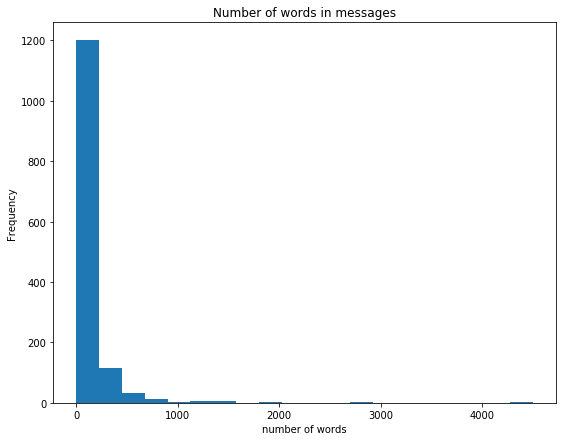

In [12]:
data.word_count.hist(grid=False, bins=20, figsize=(9,7))
plt.xlabel('number of words')
plt.ylabel('Frequency')
plt.title('Number of words in messages')
plt.show()

In [13]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

data['avg_word'] = data['body'].apply(lambda x: avg_word(x))
data[['body','avg_word']].head()

,body,avg_word
0,here is our forecast,4.250000
1,traveling to have a business meeting take the ...,4.467153
2,test successful way to go,4.200000
3,randycan you send me a schedule of the salary ...,4.666667
4,let shoot for tuesday at 1145,4.000000


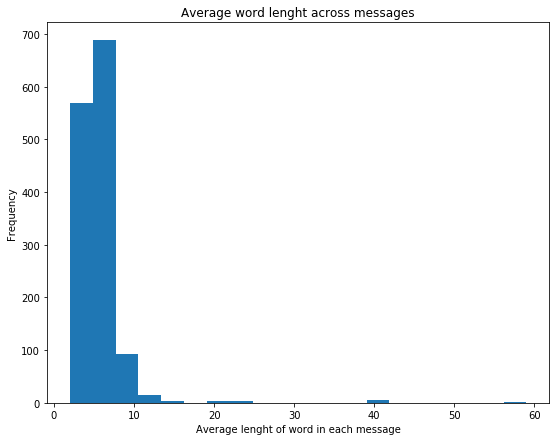

In [14]:
data.avg_word.hist(grid=False, bins=20, figsize=(9,7))
plt.xlabel('Average lenght of word in each message')
plt.ylabel('Frequency')
plt.title('Average word lenght across messages')
plt.show()

In [15]:
#from nltk.corpus import stopwords
stop = stopwords.words('english')

data['stopwords'] = data['body'].apply(lambda x: len([x for x in x.split() if x in stop]))
data[['body','stopwords']].head()

,body,stopwords
0,here is our forecast,3
1,traveling to have a business meeting take the ...,62
2,test successful way to go,1
3,randycan you send me a schedule of the salary ...,16
4,let shoot for tuesday at 1145,2


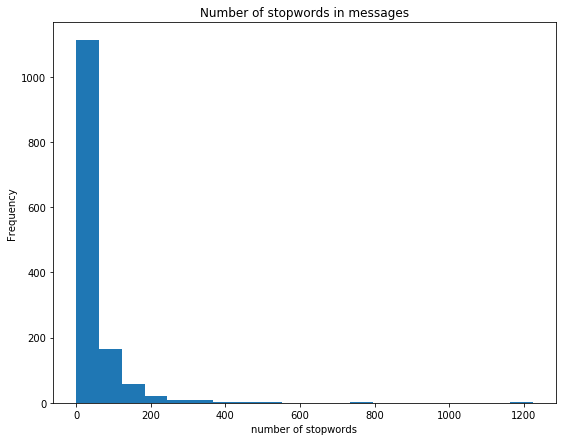

In [16]:
data.stopwords.hist(grid=False, bins=20, figsize=(9,7))
plt.xlabel('number of stopwords')
plt.ylabel('Frequency')
plt.title('Number of stopwords in messages')
plt.show()

In [17]:
stop = stopwords.words('english')
data['body'] = data['body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['body'].head()

0                                             forecast
1    traveling business meeting take fun trip espec...
2                               test successful way go
3    randycan send schedule salary level everyone t...
4                               let shoot tuesday 1145
Name: body, dtype: object

In [18]:
data['body'] = data['body'].apply(lambda x: " ".join(x for x in x.split() if x !='image'))
data['body'].head()

0                                             forecast
1    traveling business meeting take fun trip espec...
2                               test successful way go
3    randycan send schedule salary level everyone t...
4                               let shoot tuesday 1145
Name: body, dtype: object

In [19]:
value_counts = pd.Series(' '.join(data['body']).split()).value_counts()[:20]
df_value_counts = pd.DataFrame(value_counts)
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ['unique_values', 'counts for course_difficulty'] # change column names

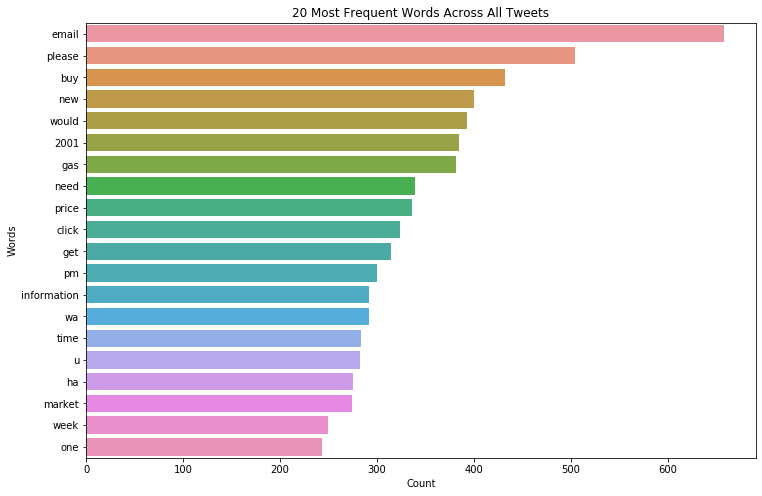

In [20]:
fig = plt.figure(figsize=(12,8))
fig = sns.barplot(x=df_value_counts['counts for course_difficulty'], y=df_value_counts['unique_values'])
fig = plt.xlabel("Count")
fig = plt.ylabel('Words')
fig = plt.title('20 Most Frequent Words Across All Tweets')
plt.show()

In [21]:
d = data['body'].str.cat(sep=' ')
tokenized = d.split()
esBigrams = ngrams(tokenized, 2)
esBigramFreq = collections.Counter(esBigrams)
bigram = pd.DataFrame(esBigramFreq.most_common(20), columns=['bigram','count'])

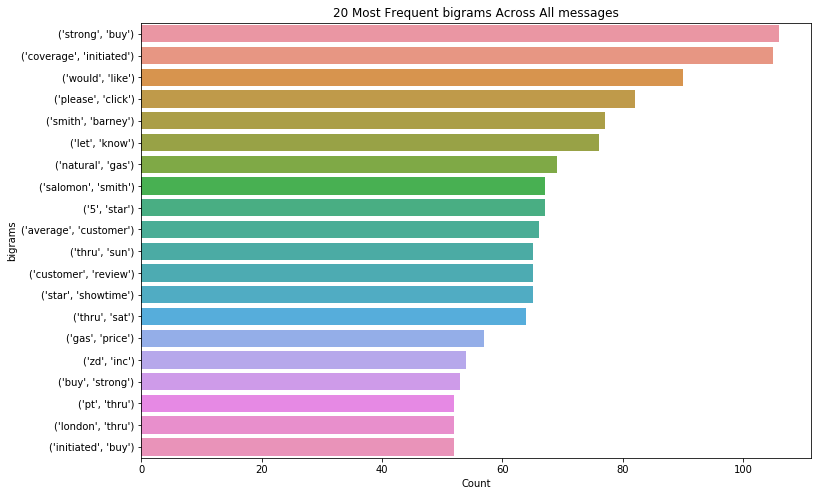

In [22]:
fig = plt.figure(figsize=(12,8))
fig = sns.barplot(x=bigram['count'], y=bigram['bigram'])
fig = plt.xlabel("Count")
fig = plt.ylabel('bigrams')
fig = plt.title('20 Most Frequent bigrams Across All messages')
plt.show()

In [23]:
esBigrams = ngrams(tokenized, 3)
esBigramFreq = collections.Counter(esBigrams)
trigram = pd.DataFrame(esBigramFreq.most_common(20), columns=['trigram','count'])

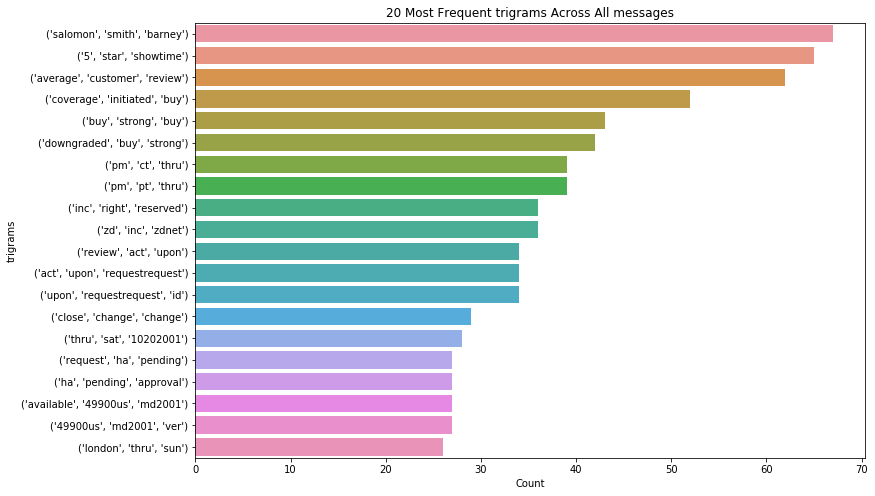

In [24]:
fig = plt.figure(figsize=(12,8))
fig = sns.barplot(x=trigram['count'], y=trigram['trigram'])
fig = plt.xlabel("Count")
fig = plt.ylabel('trigrams')
fig = plt.title('20 Most Frequent trigrams Across All messages')
plt.show()

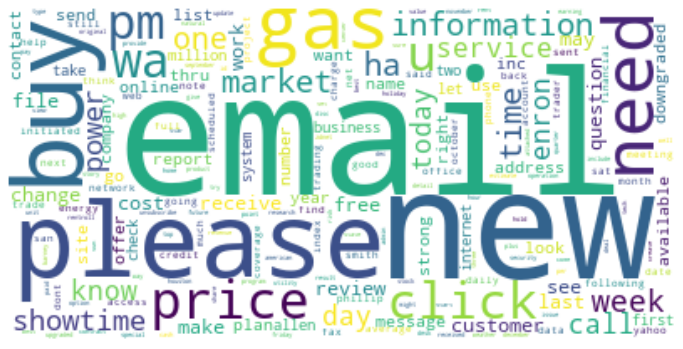

In [25]:
from wordcloud import WordCloud, STOPWORDS
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(d)
fig = plt.figure(1,figsize=(12,12))
plt.axis("off")
plt.imshow(word_cloud, interpolation='bilinear')
plt.show()

In [26]:
data['numerics'] = data['body'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
data[['body','numerics']].head()

,body,numerics
0,forecast,0
1,traveling business meeting take fun trip espec...,0
2,test successful way go,0
3,randycan send schedule salary level everyone t...,0
4,let shoot tuesday 1145,1


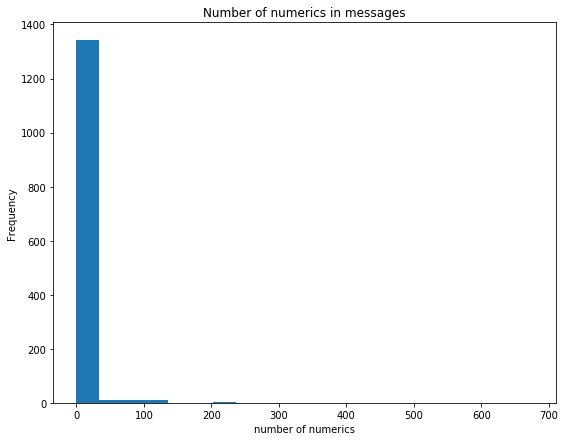

In [27]:
data.numerics.hist(grid=False, bins=20, figsize=(9,7))
plt.xlabel('number of numerics')
plt.ylabel('Frequency')
plt.title('Number of numerics in messages')
plt.show()

In [28]:
data.head()

,body,from,to,word_count,avg_word,stopwords,numerics
0,forecast,phillip.allen@enron.com,tim.belden@enron.com,4,4.250000,3,0
1,traveling business meeting take fun trip espec...,phillip.allen@enron.com,john.lavorato@enron.com,137,4.467153,62,0
2,test successful way go,phillip.allen@enron.com,leah.arsdall@enron.com,5,4.200000,1,0
3,randycan send schedule salary level everyone t...,phillip.allen@enron.com,randall.gay@enron.com,30,4.666667,16,0
4,let shoot tuesday 1145,phillip.allen@enron.com,greg.piper@enron.com,6,4.000000,2,1


In [29]:
data['dollar_sign'] = data['body'].apply(lambda x: len([x for x in x.split() if x.startswith('$')]))
data[['body','dollar_sign']].head()

,body,dollar_sign
0,forecast,0
1,traveling business meeting take fun trip espec...,0
2,test successful way go,0
3,randycan send schedule salary level everyone t...,0
4,let shoot tuesday 1145,0


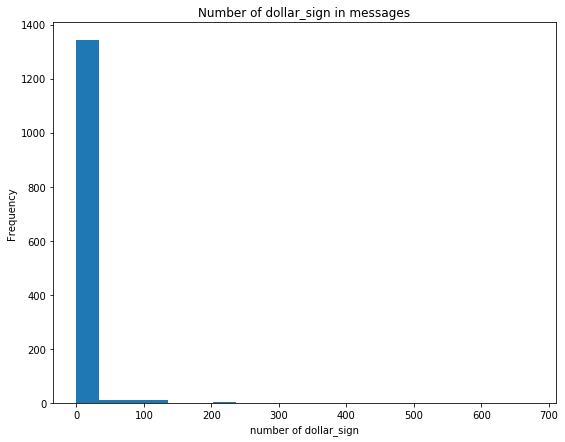

In [30]:
data.numerics.hist(grid=False, bins=20, figsize=(9,7))
plt.xlabel('number of dollar_sign')
plt.ylabel('Frequency')
plt.title('Number of dollar_sign in messages')
plt.show()

In [31]:
#data['body'] = data['body'].apply(lambda x: TextBlob(x).words)
#data.head()

In [32]:
#from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word')
X = tfidf.fit_transform(data['body'])


# <center> PCA </center>

Text(0, 0.5, 'cumulative explained variance')

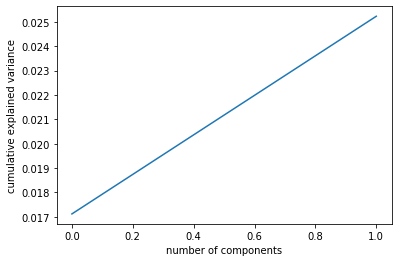

In [33]:
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

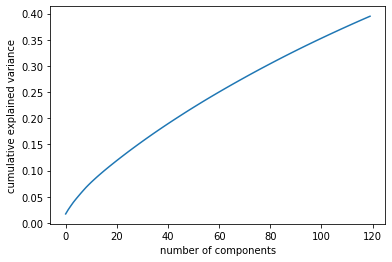

In [34]:
pca = PCA(n_components=120).fit(X_dense)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

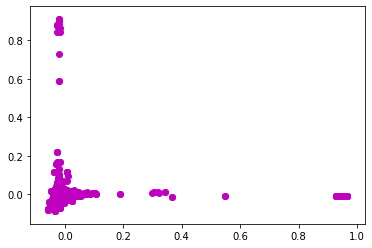

In [35]:
coords = PCA(n_components=2).fit_transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c = 'm')

In [36]:
c = pd.DataFrame(coords, columns=['pca_1','pca_2'])

In [37]:
c[['pca_1','pca_2']]

,pca_1,pca_2
0,-0.024388,0.004237
1,-0.040924,-0.045544
2,-0.022549,-0.006958
3,-0.031081,-0.015172
4,-0.025003,-0.009127
...,...,...
1376,-0.036651,0.114703
1377,-0.037290,0.009390
1378,-0.028155,0.003582
1379,-0.028952,-0.004233


# <center> K-means </center>

In [38]:
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, init='k-means++',n_init=10)
    kmeans.fit(X_dense)
    sse.append(kmeans.inertia_)

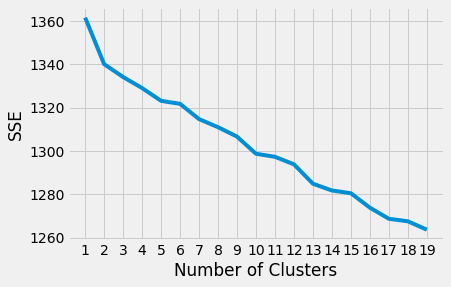

In [39]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [40]:
clf = KMeans(n_clusters = 3, max_iter = 100, init = 'k-means++', n_init = 1)
labels = clf.fit_predict(X_dense)

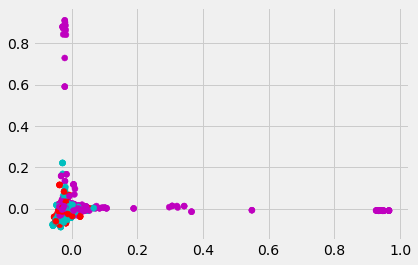

In [41]:
label_colours = ['c', 'm', 'r']
colours = [label_colours[i] for i in labels]
plt.scatter(coords[:, 0], coords[:, 1], c = colours)

# <center> hierarchical </center>

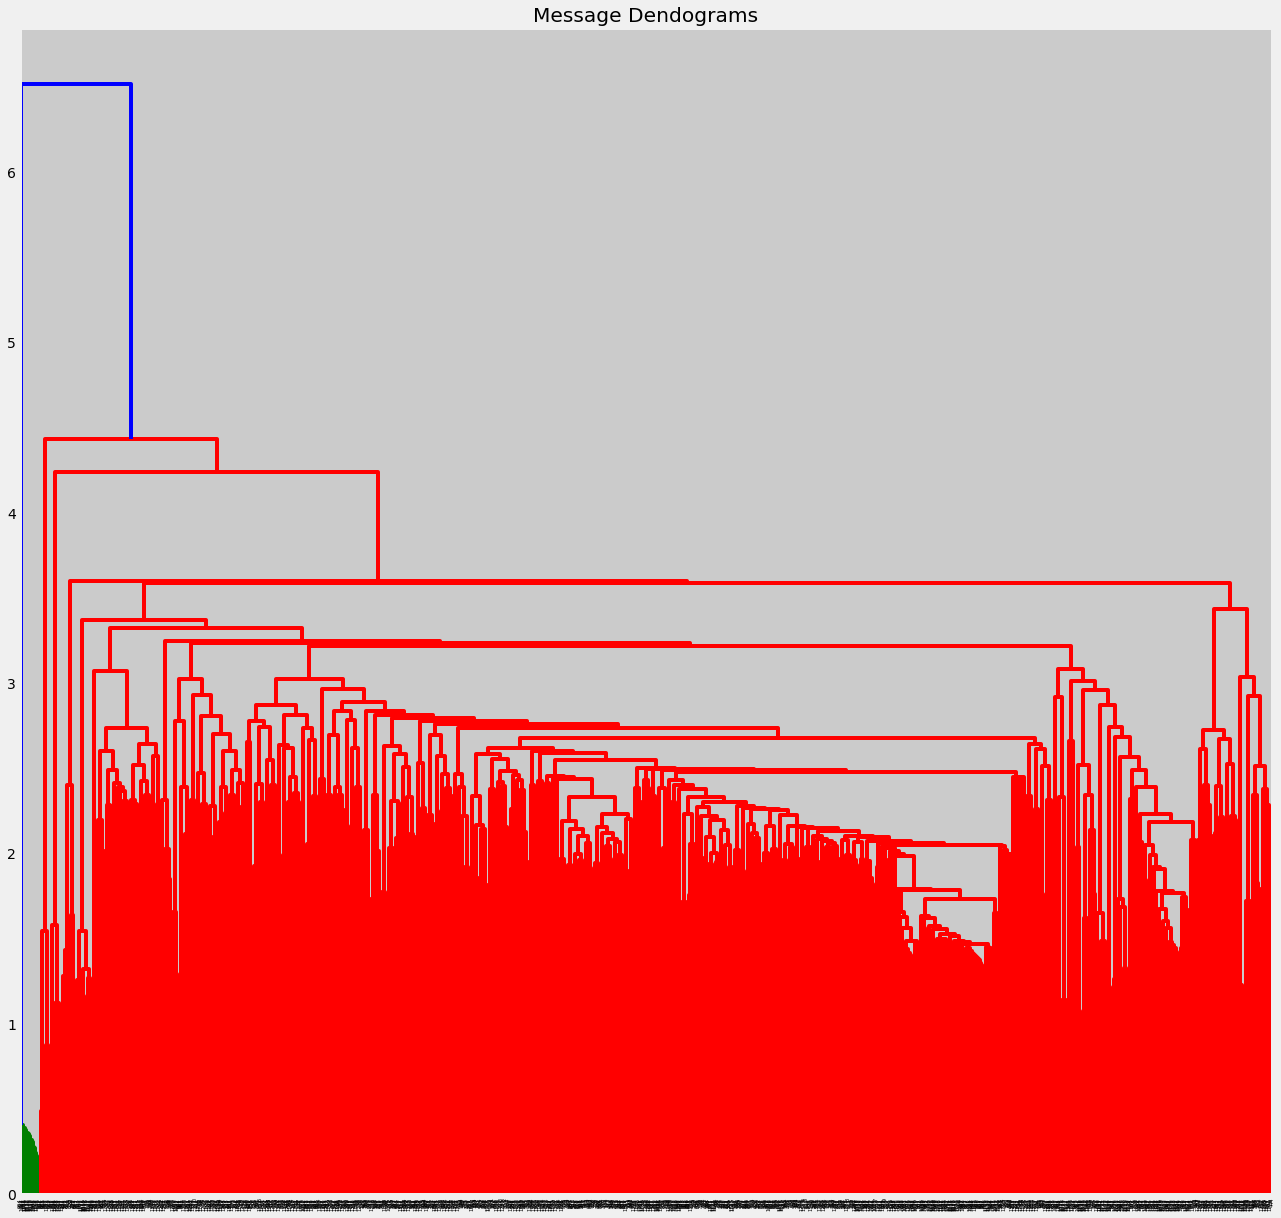

In [42]:
plt.figure(figsize=(20,20))
plt.title("Message Dendograms")
dend = shc.dendrogram(shc.linkage(X_dense, method='ward'))
plt.show()

# <center>DBSCAN</center>

In [48]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(c[['pca_1','pca_2']])
distances, indices = nbrs.kneighbors(c[['pca_1','pca_2']])

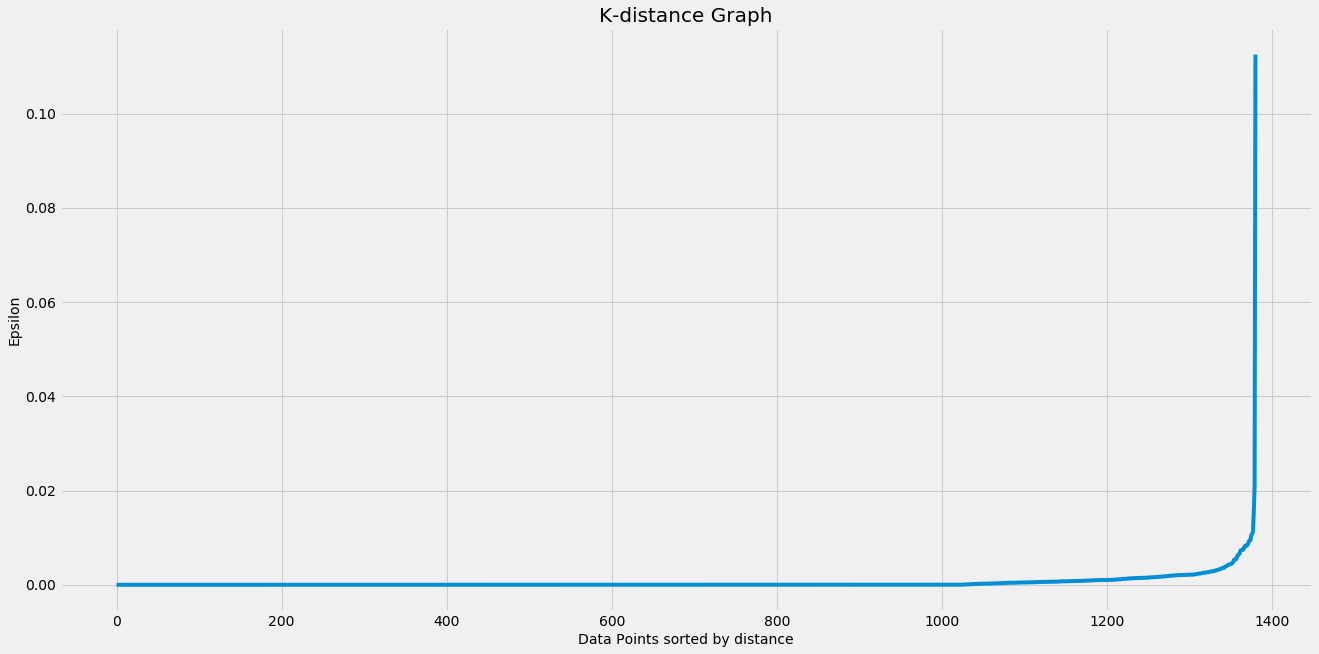

In [49]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [50]:
dbscan_opt=DBSCAN(eps=0.04,min_samples=11)
dbscan_opt.fit(c[['pca_1','pca_2']])

DBSCAN(algorithm='auto', eps=0.04, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=11, n_jobs=None, p=None)

In [51]:
c['DBSCAN_opt_labels']=dbscan_opt.labels_
c['DBSCAN_opt_labels'].value_counts()

 0    1328
 1      23
-1      19
 2      11
Name: DBSCAN_opt_labels, dtype: int64

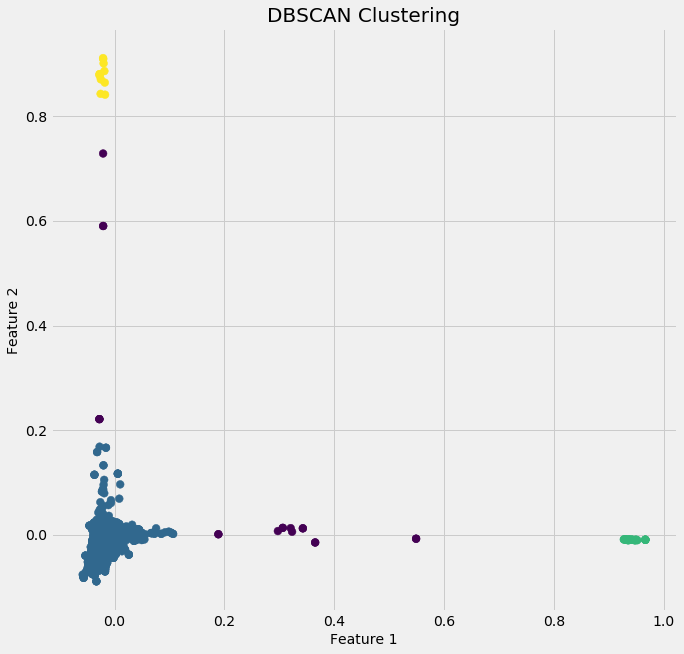

In [52]:
# Plotting the resulting clusters


plt.figure(figsize=(10,10))
plt.scatter(c['pca_1'],c['pca_2'],c=c['DBSCAN_opt_labels'],s=60)
plt.title('DBSCAN Clustering',fontsize=20)
plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
plt.show()